<a href="https://colab.research.google.com/github/RohanGforwork/sam-ai/blob/main/sam_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from tqdm import tqdm
import os



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

RAW_FOLDER = "/content/drive/MyDrive/pragathi/data/raw"
TAGGED_FOLDER = "/content/drive/MyDrive/pragathi/data/tagged"
SHAPEFILE_PATH = "/content/drive/MyDrive/pragathi/data/shapefile/ne_110m_admin_0_countries.shp"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)


In [ ]:

print("Loading shapefile...")
world = gpd.read_file("/content/drive/MyDrive/pragathi/data/shapefile")
print("Shapefile loaded.")

def tag_country(df):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    gdf = gpd.sjoin(gdf, world[['geometry', 'ADMIN']], how='left', predicate='within')
    gdf = gdf.rename(columns={'ADMIN': 'country'})
    return gdf.drop(columns=['geometry', 'index_right'])

for filename in os.listdir(RAW_FOLDER):
    if filename.endswith(".csv"):
        print(f"\n📦 Processing: {filename}")
        df = pd.read_csv(os.path.join(RAW_FOLDER, filename))

        chunk_size = 100_000
        chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
        tagged_chunks = []

        for chunk in tqdm(chunks):
            tagged = tag_country(chunk)
            tagged_chunks.append(tagged)

        final_df = pd.concat(tagged_chunks)
        output_file = os.path.join(TAGGED_FOLDER, f"tagged_{filename}")
        final_df.to_csv(output_file, index=False)
        print(f"✅ Saved tagged file to: {output_file}")

Loading shapefile...
Shapefile loaded.

📦 Processing: 20-21.csv


100%|██████████| 208/208 [14:41<00:00,  4.24s/it]


✅ Saved tagged file to: /content/drive/MyDrive/pragathi/data/tagged/tagged_20-21.csv

📦 Processing: 21-22.csv


100%|██████████| 204/204 [14:28<00:00,  4.26s/it]


✅ Saved tagged file to: /content/drive/MyDrive/pragathi/data/tagged/tagged_21-22.csv

📦 Processing: 22-23.csv


100%|██████████| 173/173 [12:16<00:00,  4.26s/it]


✅ Saved tagged file to: /content/drive/MyDrive/pragathi/data/tagged/tagged_22-23.csv

📦 Processing: 23-24.csv


100%|██████████| 219/219 [15:18<00:00,  4.19s/it]


✅ Saved tagged file to: /content/drive/MyDrive/pragathi/data/tagged/tagged_23-24.csv

📦 Processing: 24-25.csv


100%|██████████| 212/212 [14:54<00:00,  4.22s/it]


✅ Saved tagged file to: /content/drive/MyDrive/pragathi/data/tagged/tagged_24-25.csv


**the preprocessing of data stops here , do not run the above code **

**start from here**

In [ ]:
import pandas as pd
import os
from glob import glob

data_dir = '/content/drive/MyDrive/pragathi/data/tagged'
all_files = sorted(glob(os.path.join(data_dir, 'tagged_*.csv')))

df_all = pd.concat([pd.read_csv(file) for file in all_files], ignore_index=True)

print(f"Loaded {len(df_all):,} total rows from {len(all_files)} files.")


Loaded 80,304,466 total rows from 4 files.


In [ ]:
import os

output_dir = '/content/drive/MyDrive/pragathi/data/combined'
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, 'combined_2020_2025.csv')
df_all.to_csv(output_file, index=False)

print(f"✅ Combined file saved to: {output_file}")



✅ Combined file saved to: /content/drive/MyDrive/pragathi/data/combined/combined_2020_2025.csv


In [ ]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/pragathi/data/combined/combined_2020_2025.csv')




In [ ]:
df.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type', 'country', 'year', 'month',
       'day', 'lat_bin', 'lon_bin'],
      dtype='object')

In [ ]:
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['year'] = df['acq_date'].dt.year
df['month'] = df['acq_date'].dt.month
df['day'] = df['acq_date'].dt.day

# --- GRID THE WORLD (0.5° x 0.5° ZONES) ---
df['lat_bin'] = df['latitude'].apply(lambda x: round(x * 2) / 2)
df['lon_bin'] = df['longitude'].apply(lambda x: round(x * 2) / 2)



In [ ]:


zone_monthly = df.groupby(['lat_bin', 'lon_bin', 'month']).agg({
    'brightness': 'mean',
    'frp': 'mean',
    'latitude': 'count'
}).reset_index().rename(columns={'latitude': 'fire_count'})


zone_monthly.rename(columns={'confidence': 'fire_count'}, inplace=True)


Classification Report:

              precision    recall  f1-score   support

        high       0.75      0.78      0.77     17474
         low       0.81      0.91      0.86     40425
      medium       0.48      0.26      0.34     12659

    accuracy                           0.76     70558
   macro avg       0.68      0.65      0.65     70558
weighted avg       0.74      0.76      0.74     70558



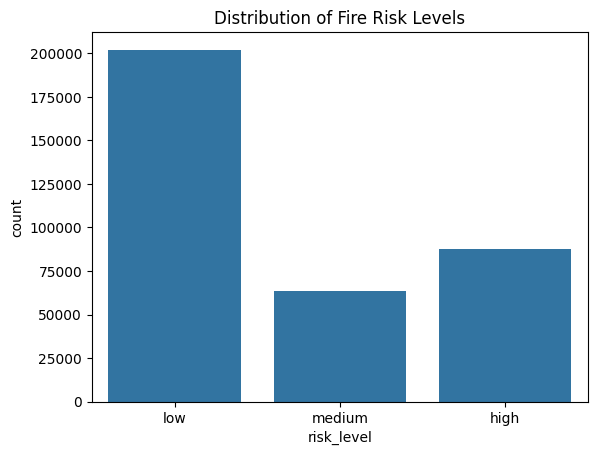

In [ ]:

def assign_risk(count):
    if count >= 100:
        return 'high'
    elif count >= 30:
        return 'medium'
    else:
        return 'low'

zone_monthly['risk_level'] = zone_monthly['fire_count'].apply(assign_risk)

zone_model = zone_monthly[['lat_bin', 'lon_bin', 'month', 'brightness', 'frp', 'risk_level']].dropna()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
zone_model['risk_encoded'] = le.fit_transform(zone_model['risk_level'])

X = zone_model[['lat_bin', 'lon_bin', 'month', 'brightness', 'frp']]
y = zone_model['risk_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

sns.countplot(x='risk_level', data=zone_model)
plt.title("Distribution of Fire Risk Levels")
plt.show()

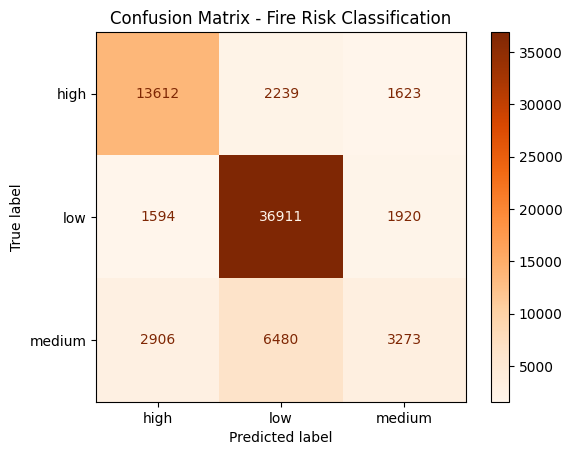

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix - Fire Risk Classification")
plt.show()


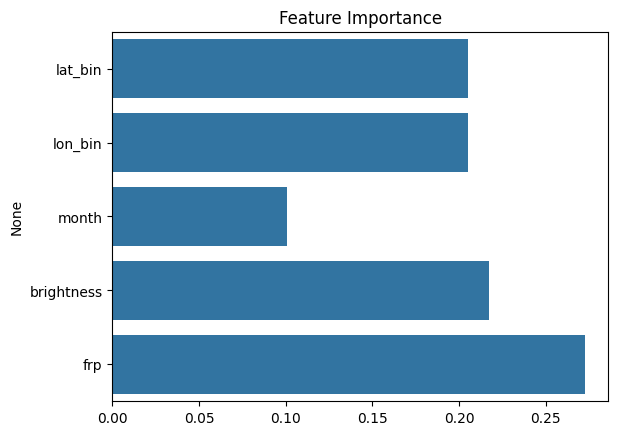

In [ ]:
importances = model.feature_importances_
features = X.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


In [ ]:
import joblib
joblib.dump(model, 'fire_risk_rf_model.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
def predict_risk(lat, lon, month, brightness, frp):
    lat_bin = round(lat * 2) / 2
    lon_bin = round(lon * 2) / 2
    X_new = pd.DataFrame([[lat_bin, lon_bin, month, brightness, frp]],
                         columns=['lat_bin', 'lon_bin', 'month', 'brightness', 'frp'])
    pred = model.predict(X_new)[0]
    return le.inverse_transform([pred])[0]


In [ ]:
import numpy as np
import pandas as pd

def predict_fire_risk(lat, lon, date_str, model, label_encoder, default_brightness, default_frp):

    date = pd.to_datetime(date_str)
    month = date.month

    lat_bin = round(lat * 2) / 2
    lon_bin = round(lon * 2) / 2

    input_data = pd.DataFrame([{
        'lat_bin': lat_bin,
        'lon_bin': lon_bin,
        'month': month,
        'brightness': default_brightness,
        'frp': default_frp
    }])

    pred_proba = model.predict_proba(input_data)[0]
    pred_class = model.predict(input_data)[0]
    pred_label = label_encoder.inverse_transform([pred_class])[0]
    confidence = np.max(pred_proba)

    return {
        'latitude': lat,
        'longitude': lon,
        'month': month,
        'risk_level': pred_label,
        'confidence': round(confidence, 2)
    }


In [ ]:
def predict_fire_risk_smart(model, label_encoder, zone_monthly, latitude, longitude, month):

    lat_bin = round(latitude * 2) / 2
    lon_bin = round(longitude * 2) / 2

    row = zone_monthly[
        (zone_monthly['lat_bin'] == lat_bin) &
        (zone_monthly['lon_bin'] == lon_bin) &
        (zone_monthly['month'] == month)
    ]

    if row.empty:
        return "❌ No historical data for this region and month"

    input_data = pd.DataFrame([{
        'lat_bin': lat_bin,
        'lon_bin': lon_bin,
        'month': month,
        'brightness': row['brightness'].values[0],
        'frp': row['frp'].values[0]
    }])

    pred_encoded = model.predict(input_data)[0]
    risk_label = label_encoder.inverse_transform([pred_encoded])[0]
    return risk_label


In [ ]:
risk = predict_fire_risk_smart(model, le, zone_monthly, 34.6, -118.3, 6)
print("🔥 Fire Risk Prediction:", risk)


🔥 Fire Risk Prediction: high


In [ ]:
def predict_fire_risk_from_data(lat, lon, date_str, model, label_encoder, zone_month_avg):
    date = pd.to_datetime(date_str)
    month = date.month

    lat_bin = round(lat * 2) / 2
    lon_bin = round(lon * 2) / 2


    match = zone_month_avg[
        (zone_month_avg['lat_bin'] == lat_bin) &
        (zone_month_avg['lon_bin'] == lon_bin) &
        (zone_month_avg['month'] == month)
    ]

    if match.empty:

        brightness = 340
        frp = 20
    else:
        brightness = match['brightness'].values[0]
        frp = match['frp'].values[0]

    input_data = pd.DataFrame([{
        'lat_bin': lat_bin,
        'lon_bin': lon_bin,
        'month': month,
        'brightness': brightness,
        'frp': frp
    }])

    pred_proba = model.predict_proba(input_data)[0]
    pred_class = model.predict(input_data)[0]
    pred_label = label_encoder.inverse_transform([pred_class])[0]
    confidence = np.max(pred_proba)

    return {
        'latitude': lat,
        'longitude': lon,
        'month': month,
        'lat_bin': lat_bin,
        'lon_bin': lon_bin,
        'risk_level': pred_label,
        'confidence': round(confidence, 2)
    }


In [ ]:

zone_month_avg = df.groupby(['lat_bin', 'lon_bin', 'month'])[['brightness', 'frp']].mean().reset_index()
df = df.rename(columns={'bright_ti4': 'brightness'})

lat = float(input("Enter Latitude: "))        # e.g., 34.6
lon = float(input("Enter Longitude: "))       # e.g., -118.3
date_str = input("Enter Date (YYYY-MM-DD): ") # e.g., 2025-04-07


result = predict_fire_risk_from_data(
    lat=lat,
    lon=lon,
    date_str=date_str,
    model=model,
    label_encoder=le,
    zone_month_avg=zone_month_avg
)

print(f"\n🔥 Fire Risk Prediction for {date_str}")
print(f"📍 Location: ({result['latitude']}, {result['longitude']})")
print(f"📅 Month: {result['month']}")
print(f"🧠 Risk Level: {result['risk_level'].upper()} (Confidence: {result['confidence']*100:.1f}%)")


NameError: name 'df' is not defined

coordinate grid interpolation - if data not available for a wide section , i.e antratica then show data not available

In [ ]:
from scipy.spatial import KDTree
import numpy as np

data_coords = df[['latitude', 'longitude']].values
tree = KDTree(data_coords)

def get_nearest_point_risk(lat, lon):
    distance, index = tree.query([lat, lon])
    nearest_row = df.iloc[index]
    features = extract_features(nearest_row)
    return model.predict([features]), model.predict_proba([features])


Xone risk for wider space model

In [ ]:
# Define 0.05-degree grid zones (adjust granularity as needed)
df['grid_lat'] = df['latitude'].round(2)
df['grid_lon'] = df['longitude'].round(2)

df['risk'] = model.predict(df[feature_cols])

zone_risk = df.groupby(['grid_lat', 'grid_lon'])['risk'].agg(lambda x: x.value_counts().idxmax()).reset_index()


trend analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


df['month'] = pd.to_datetime(df['acq_date']).dt.month
df['year'] = pd.to_datetime(df['acq_date']).dt.year

# Trend by month
monthly_trend = df.groupby('month').size().reset_index(name='fire_count')

sns.lineplot(data=monthly_trend, x='month', y='fire_count')
plt.title("🔥 Monthly Forest Fire Trend")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.grid(True)
plt.show()
